# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

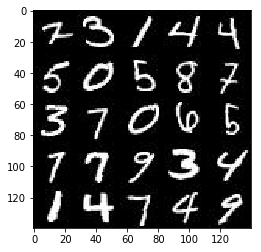

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

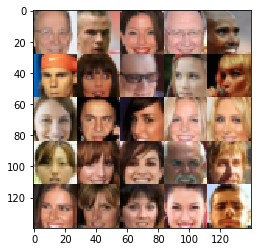

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    inputs_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    lr = tf.placeholder(tf.float32, name = 'learnin_rate')

    return inputs_real, inputs_z, lr


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/home/kslin/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/home/kslin/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/home/kslin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/home/kslin/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/home/kslin/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 477, in start\n    ioloop.IOLoop.instance().start()', 'File "/home/kslin/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloo

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 28x28x3
        # First fully connected layer
        x1 = tf.layers.conv2d(images, 64, 3, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        x2 = tf.layers.conv2d(relu1, 128, 3, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        x3 = tf.layers.conv2d(relu2, 256, 3, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 7x7x128
        x4 = tf.layers.conv2d(relu3, 512, 3, strides=2, padding='same')
        bn4 = tf.layers.batch_normalization(x4, training=True)
        relu4 = tf.maximum(alpha * bn4, bn4)
        # 4x4x256
        # Flatten it
        flat = tf.reshape(relu3, (-1, 2*2*512))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    alpha = 0.2
    with tf.variable_scope('generator', reuse= not is_train):#sampling reuse = true
        # First fully connected layer
        x1 = tf.layers.dense(z, 2*2*512)
        x1 = tf.reshape(x1, (-1, 2, 2, 512))
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha * x1, x1)
        # CONV1 7*7*256
        conv1 = tf.layers.conv2d_transpose(x1, 256, 5, strides = 2, padding='valid')
        conv1 = tf.layers.batch_normalization (conv1, training=is_train) 
        conv1 = tf.maximum(alpha*conv1, conv1)
        # CONV2 14*14*128
        conv2 = tf.layers.conv2d_transpose(conv1, 128, 3, strides = 2, padding='same')
        conv2 = tf.layers.batch_normalization (conv2, training=is_train) 
        conv2 = tf.maximum(alpha*conv2, conv2)
        # CONV3 28*28*64
        conv3 = tf.layers.conv2d_transpose(conv2, 64, 3, strides = 2, padding='same')
        conv3 = tf.layers.batch_normalization (conv3, training=is_train) 
        conv3 = tf.maximum(alpha*conv3, conv3)
        
        # Output layer, 28x28x3
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 3, strides = 1, padding='same')
        
        # 0.5 is for training data are nomalized to rang -0.5~0.5
        out = tf.tanh(logits) * 0.5
        
            
        return out

    #https://stackoverflow.com/documentation/tensorflow/9640/using-transposed-convolution-layers#t=201709191924161737795

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt
    

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [15]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #if (data_image_mode == "RGB"):
    #    image_channel = 3
    #else:
    #    image_channel = 1
        
    #print(data_shape)
        
    #out_channel_dim = data_shape[0]
    _, img_height, img_width, img_channel = data_shape

    inputs_real, inputs_z, lr = model_inputs(img_width, img_height, img_channel, z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, img_channel)
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    #print (data_shape[0])
    #print (data_shape[1])
    #print (data_shape[2])
    #print (data_shape[3])
    #print (img_width)
    #print (img_height)
    #print (img_channel)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_dim))
    samples, losses = [], []
    steps = 0
    print_every = 20
    show_every = 100
    n_images = 25
    
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                
                # I believe I don't have to apply batch_images *= 2 suggested by last reviewer
                # Because I have put "out = tf.tanh(logits) * 0.5" in generator

                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_train_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    
                    show_generator_output(sess, n_images, inputs_z, img_channel, data_image_mode)
                    
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.1534... Generator Loss: 2.8192
Epoch 1/2... Discriminator Loss: 0.4184... Generator Loss: 1.9728
Epoch 1/2... Discriminator Loss: 1.3433... Generator Loss: 0.5774
Epoch 1/2... Discriminator Loss: 0.5005... Generator Loss: 2.0172
Epoch 1/2... Discriminator Loss: 0.3730... Generator Loss: 2.0093


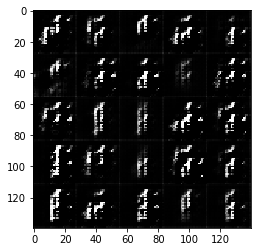

Epoch 1/2... Discriminator Loss: 0.3819... Generator Loss: 2.1749
Epoch 1/2... Discriminator Loss: 1.0127... Generator Loss: 2.6396
Epoch 1/2... Discriminator Loss: 0.6298... Generator Loss: 3.7592
Epoch 1/2... Discriminator Loss: 0.7827... Generator Loss: 1.3501
Epoch 1/2... Discriminator Loss: 0.9926... Generator Loss: 1.8488


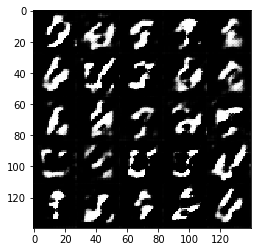

Epoch 1/2... Discriminator Loss: 0.9729... Generator Loss: 0.8756
Epoch 1/2... Discriminator Loss: 1.6446... Generator Loss: 2.8046
Epoch 1/2... Discriminator Loss: 0.6737... Generator Loss: 1.2949
Epoch 1/2... Discriminator Loss: 0.8573... Generator Loss: 0.9304
Epoch 1/2... Discriminator Loss: 0.8658... Generator Loss: 1.1537


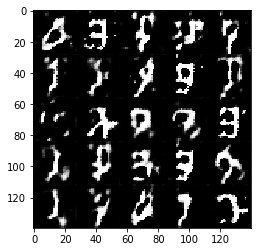

Epoch 1/2... Discriminator Loss: 1.0351... Generator Loss: 2.7325
Epoch 1/2... Discriminator Loss: 0.8207... Generator Loss: 1.5198
Epoch 1/2... Discriminator Loss: 1.0039... Generator Loss: 1.0676
Epoch 1/2... Discriminator Loss: 1.3345... Generator Loss: 0.4767
Epoch 1/2... Discriminator Loss: 1.0650... Generator Loss: 0.8008


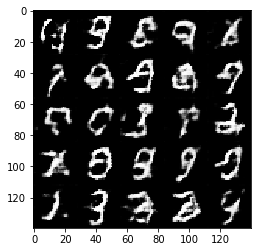

Epoch 1/2... Discriminator Loss: 1.2272... Generator Loss: 1.8295
Epoch 1/2... Discriminator Loss: 1.0086... Generator Loss: 1.2940
Epoch 1/2... Discriminator Loss: 1.0232... Generator Loss: 0.8605
Epoch 1/2... Discriminator Loss: 1.4479... Generator Loss: 0.4166
Epoch 1/2... Discriminator Loss: 1.5770... Generator Loss: 1.9428


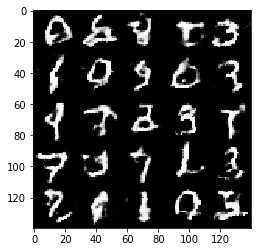

Epoch 1/2... Discriminator Loss: 0.9107... Generator Loss: 1.0647
Epoch 1/2... Discriminator Loss: 1.6043... Generator Loss: 0.3566
Epoch 1/2... Discriminator Loss: 1.1243... Generator Loss: 0.7484
Epoch 1/2... Discriminator Loss: 1.0881... Generator Loss: 0.8440
Epoch 1/2... Discriminator Loss: 1.0766... Generator Loss: 1.1408


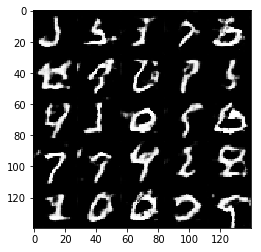

Epoch 1/2... Discriminator Loss: 1.4586... Generator Loss: 2.0862
Epoch 1/2... Discriminator Loss: 1.0633... Generator Loss: 1.0458
Epoch 1/2... Discriminator Loss: 1.4898... Generator Loss: 0.3507
Epoch 1/2... Discriminator Loss: 1.1315... Generator Loss: 0.8107
Epoch 1/2... Discriminator Loss: 1.6724... Generator Loss: 0.3054


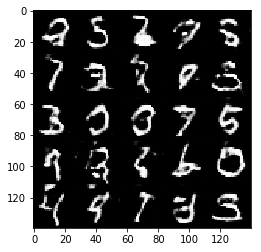

Epoch 1/2... Discriminator Loss: 1.0226... Generator Loss: 1.0709
Epoch 1/2... Discriminator Loss: 1.4375... Generator Loss: 1.5395
Epoch 1/2... Discriminator Loss: 0.9372... Generator Loss: 0.8943
Epoch 1/2... Discriminator Loss: 1.0355... Generator Loss: 0.9408
Epoch 1/2... Discriminator Loss: 1.1607... Generator Loss: 1.5395


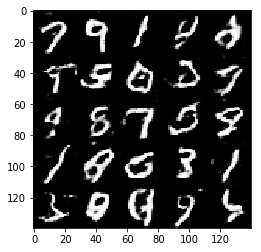

Epoch 1/2... Discriminator Loss: 1.0542... Generator Loss: 0.7594
Epoch 1/2... Discriminator Loss: 1.2128... Generator Loss: 1.5072
Epoch 1/2... Discriminator Loss: 1.0808... Generator Loss: 1.2285
Epoch 1/2... Discriminator Loss: 1.2778... Generator Loss: 1.0843
Epoch 1/2... Discriminator Loss: 1.1621... Generator Loss: 0.7973


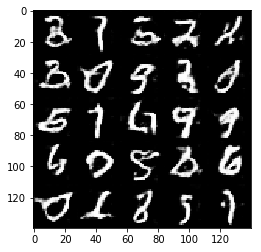

Epoch 1/2... Discriminator Loss: 1.4734... Generator Loss: 1.5704
Epoch 2/2... Discriminator Loss: 1.3487... Generator Loss: 0.8163
Epoch 2/2... Discriminator Loss: 1.2773... Generator Loss: 1.4043
Epoch 2/2... Discriminator Loss: 1.0916... Generator Loss: 0.8496
Epoch 2/2... Discriminator Loss: 1.2075... Generator Loss: 1.0120


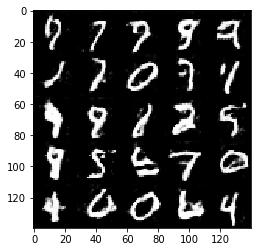

Epoch 2/2... Discriminator Loss: 1.1929... Generator Loss: 1.3899
Epoch 2/2... Discriminator Loss: 1.0601... Generator Loss: 1.1422
Epoch 2/2... Discriminator Loss: 1.1889... Generator Loss: 0.6522
Epoch 2/2... Discriminator Loss: 1.0902... Generator Loss: 1.3111
Epoch 2/2... Discriminator Loss: 1.4594... Generator Loss: 0.4099


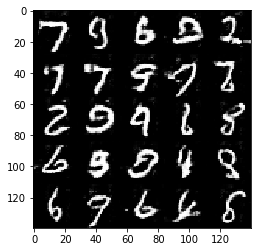

Epoch 2/2... Discriminator Loss: 1.2952... Generator Loss: 1.1768
Epoch 2/2... Discriminator Loss: 1.1848... Generator Loss: 1.5198
Epoch 2/2... Discriminator Loss: 1.2865... Generator Loss: 0.5214
Epoch 2/2... Discriminator Loss: 1.3979... Generator Loss: 1.6370
Epoch 2/2... Discriminator Loss: 1.1952... Generator Loss: 0.7952


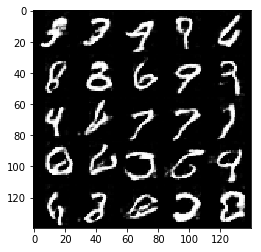

Epoch 2/2... Discriminator Loss: 1.0672... Generator Loss: 0.9841
Epoch 2/2... Discriminator Loss: 2.5538... Generator Loss: 0.1152
Epoch 2/2... Discriminator Loss: 1.1891... Generator Loss: 0.7082
Epoch 2/2... Discriminator Loss: 1.1533... Generator Loss: 1.4173
Epoch 2/2... Discriminator Loss: 1.2014... Generator Loss: 1.7047


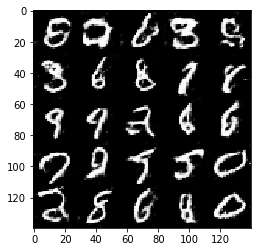

Epoch 2/2... Discriminator Loss: 1.2901... Generator Loss: 0.5048
Epoch 2/2... Discriminator Loss: 1.0580... Generator Loss: 0.9640
Epoch 2/2... Discriminator Loss: 1.5566... Generator Loss: 0.3417
Epoch 2/2... Discriminator Loss: 1.9890... Generator Loss: 0.2518
Epoch 2/2... Discriminator Loss: 1.1611... Generator Loss: 0.6086


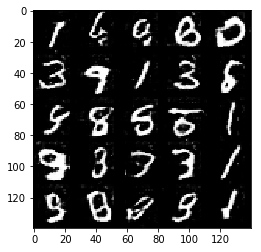

Epoch 2/2... Discriminator Loss: 0.9696... Generator Loss: 0.8104
Epoch 2/2... Discriminator Loss: 1.0894... Generator Loss: 0.6702
Epoch 2/2... Discriminator Loss: 1.1572... Generator Loss: 1.5074
Epoch 2/2... Discriminator Loss: 1.1819... Generator Loss: 0.7907
Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 1.2237


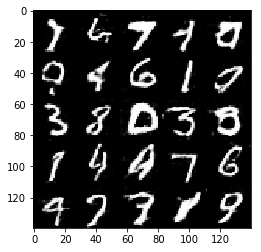

Epoch 2/2... Discriminator Loss: 1.1121... Generator Loss: 0.7974
Epoch 2/2... Discriminator Loss: 1.2769... Generator Loss: 1.3315
Epoch 2/2... Discriminator Loss: 1.5861... Generator Loss: 0.3715
Epoch 2/2... Discriminator Loss: 1.1246... Generator Loss: 1.3581
Epoch 2/2... Discriminator Loss: 2.0408... Generator Loss: 1.7312


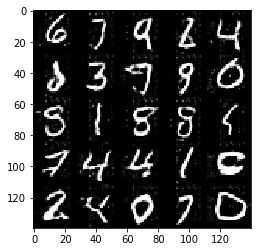

Epoch 2/2... Discriminator Loss: 1.1156... Generator Loss: 0.7772
Epoch 2/2... Discriminator Loss: 1.2855... Generator Loss: 0.5899
Epoch 2/2... Discriminator Loss: 1.0219... Generator Loss: 0.7546
Epoch 2/2... Discriminator Loss: 1.0436... Generator Loss: 0.9710
Epoch 2/2... Discriminator Loss: 1.1532... Generator Loss: 0.5488


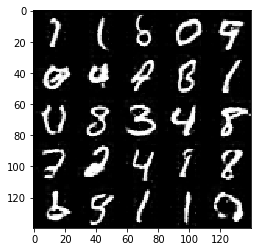

Epoch 2/2... Discriminator Loss: 1.0910... Generator Loss: 0.6341
Epoch 2/2... Discriminator Loss: 1.0814... Generator Loss: 1.1156
Epoch 2/2... Discriminator Loss: 1.3709... Generator Loss: 0.3867
Epoch 2/2... Discriminator Loss: 1.0602... Generator Loss: 0.7195
Epoch 2/2... Discriminator Loss: 1.0991... Generator Loss: 0.9799


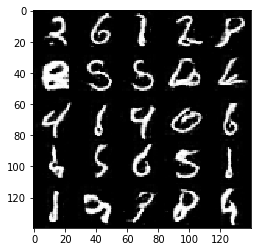

Epoch 2/2... Discriminator Loss: 0.7858... Generator Loss: 1.3075
Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 1.0144
Epoch 2/2... Discriminator Loss: 1.1483... Generator Loss: 0.6588


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

In [13]:
print (mnist_dataset.shape)

(60000, 28, 28, 1)


### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5031... Generator Loss: 1.4074
Epoch 1/1... Discriminator Loss: 0.2861... Generator Loss: 2.0165
Epoch 1/1... Discriminator Loss: 0.2426... Generator Loss: 2.2556
Epoch 1/1... Discriminator Loss: 0.3030... Generator Loss: 1.9345
Epoch 1/1... Discriminator Loss: 0.1642... Generator Loss: 2.3106


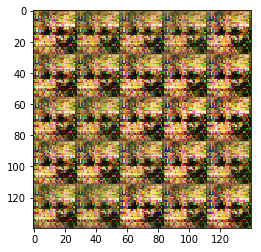

Epoch 1/1... Discriminator Loss: 0.1411... Generator Loss: 2.4984
Epoch 1/1... Discriminator Loss: 0.4362... Generator Loss: 1.7290
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 6.7145
Epoch 1/1... Discriminator Loss: 0.3480... Generator Loss: 3.5352
Epoch 1/1... Discriminator Loss: 0.6736... Generator Loss: 0.9850


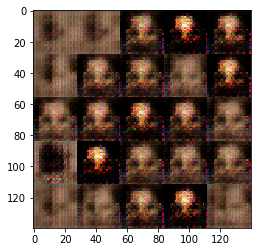

Epoch 1/1... Discriminator Loss: 0.9293... Generator Loss: 1.4798
Epoch 1/1... Discriminator Loss: 0.6814... Generator Loss: 1.9304
Epoch 1/1... Discriminator Loss: 1.1146... Generator Loss: 0.5256
Epoch 1/1... Discriminator Loss: 1.0644... Generator Loss: 1.6372
Epoch 1/1... Discriminator Loss: 1.6517... Generator Loss: 0.4479


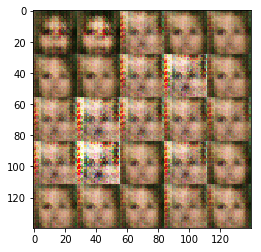

Epoch 1/1... Discriminator Loss: 0.8861... Generator Loss: 1.2055
Epoch 1/1... Discriminator Loss: 1.1365... Generator Loss: 1.1407
Epoch 1/1... Discriminator Loss: 0.9911... Generator Loss: 0.9109
Epoch 1/1... Discriminator Loss: 1.4490... Generator Loss: 1.9355
Epoch 1/1... Discriminator Loss: 1.3956... Generator Loss: 1.0108


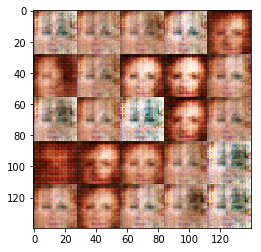

Epoch 1/1... Discriminator Loss: 0.9764... Generator Loss: 0.9145
Epoch 1/1... Discriminator Loss: 1.1679... Generator Loss: 1.2939
Epoch 1/1... Discriminator Loss: 1.1695... Generator Loss: 0.8629
Epoch 1/1... Discriminator Loss: 1.2260... Generator Loss: 0.9270
Epoch 1/1... Discriminator Loss: 0.9829... Generator Loss: 0.7537


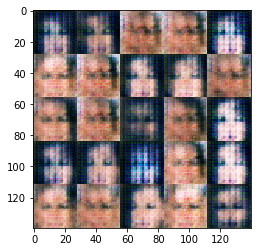

Epoch 1/1... Discriminator Loss: 1.0758... Generator Loss: 1.5023
Epoch 1/1... Discriminator Loss: 1.0406... Generator Loss: 0.7837
Epoch 1/1... Discriminator Loss: 0.8715... Generator Loss: 1.2606
Epoch 1/1... Discriminator Loss: 0.8977... Generator Loss: 1.5876
Epoch 1/1... Discriminator Loss: 1.0973... Generator Loss: 0.7401


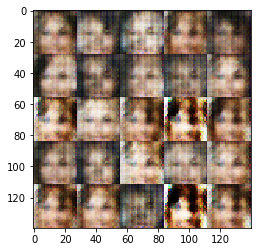

Epoch 1/1... Discriminator Loss: 1.0568... Generator Loss: 0.9501
Epoch 1/1... Discriminator Loss: 1.3903... Generator Loss: 0.5943
Epoch 1/1... Discriminator Loss: 1.2816... Generator Loss: 0.8065
Epoch 1/1... Discriminator Loss: 1.2427... Generator Loss: 1.0864
Epoch 1/1... Discriminator Loss: 1.3774... Generator Loss: 0.8771


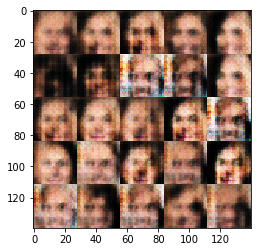

Epoch 1/1... Discriminator Loss: 1.1499... Generator Loss: 1.0029
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.3580
Epoch 1/1... Discriminator Loss: 0.8607... Generator Loss: 1.0214
Epoch 1/1... Discriminator Loss: 1.0592... Generator Loss: 1.5561
Epoch 1/1... Discriminator Loss: 0.9113... Generator Loss: 0.8985


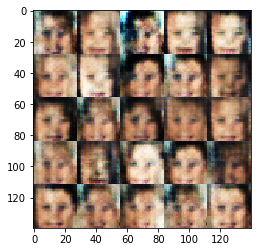

Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 1.0699
Epoch 1/1... Discriminator Loss: 1.0822... Generator Loss: 0.8429
Epoch 1/1... Discriminator Loss: 0.9476... Generator Loss: 0.9654
Epoch 1/1... Discriminator Loss: 1.2337... Generator Loss: 2.3716
Epoch 1/1... Discriminator Loss: 0.9416... Generator Loss: 1.0865


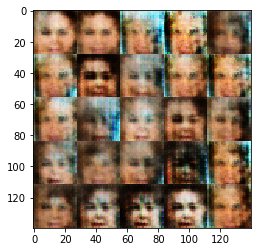

Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.9469
Epoch 1/1... Discriminator Loss: 1.3550... Generator Loss: 0.6765
Epoch 1/1... Discriminator Loss: 0.9109... Generator Loss: 1.0534
Epoch 1/1... Discriminator Loss: 0.8671... Generator Loss: 1.1606
Epoch 1/1... Discriminator Loss: 0.8778... Generator Loss: 1.1574


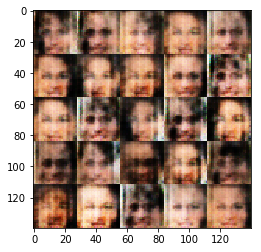

Epoch 1/1... Discriminator Loss: 1.0321... Generator Loss: 1.1281
Epoch 1/1... Discriminator Loss: 1.1190... Generator Loss: 1.5113
Epoch 1/1... Discriminator Loss: 0.9538... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.1123... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.0968... Generator Loss: 0.9928


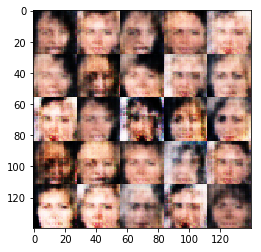

Epoch 1/1... Discriminator Loss: 0.8238... Generator Loss: 1.0452
Epoch 1/1... Discriminator Loss: 1.1250... Generator Loss: 1.0408
Epoch 1/1... Discriminator Loss: 0.9251... Generator Loss: 1.3859
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 0.8991... Generator Loss: 1.0133


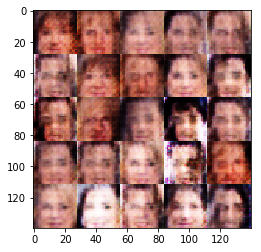

Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 0.7289
Epoch 1/1... Discriminator Loss: 1.1304... Generator Loss: 0.7854
Epoch 1/1... Discriminator Loss: 1.1743... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.2494... Generator Loss: 0.8801
Epoch 1/1... Discriminator Loss: 1.2554... Generator Loss: 0.8237


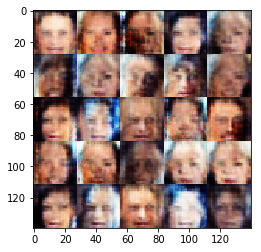

Epoch 1/1... Discriminator Loss: 1.1045... Generator Loss: 1.1432
Epoch 1/1... Discriminator Loss: 0.9818... Generator Loss: 0.8533
Epoch 1/1... Discriminator Loss: 1.1723... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.2918... Generator Loss: 0.5403
Epoch 1/1... Discriminator Loss: 1.3277... Generator Loss: 0.5418


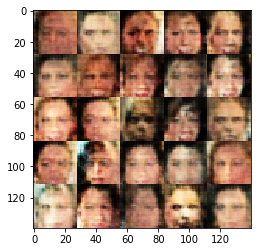

Epoch 1/1... Discriminator Loss: 1.1317... Generator Loss: 0.9924
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 0.9548
Epoch 1/1... Discriminator Loss: 1.0858... Generator Loss: 1.1115
Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 1.1086
Epoch 1/1... Discriminator Loss: 1.2315... Generator Loss: 0.6763


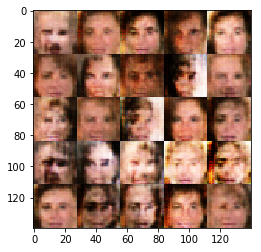

Epoch 1/1... Discriminator Loss: 1.0759... Generator Loss: 0.8426
Epoch 1/1... Discriminator Loss: 1.0544... Generator Loss: 1.2346
Epoch 1/1... Discriminator Loss: 0.9453... Generator Loss: 1.5357
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 1.0018
Epoch 1/1... Discriminator Loss: 1.0048... Generator Loss: 0.9577


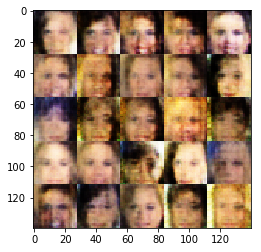

Epoch 1/1... Discriminator Loss: 1.1601... Generator Loss: 0.8625
Epoch 1/1... Discriminator Loss: 1.3743... Generator Loss: 0.5087
Epoch 1/1... Discriminator Loss: 1.0404... Generator Loss: 0.9792
Epoch 1/1... Discriminator Loss: 1.0835... Generator Loss: 0.9756
Epoch 1/1... Discriminator Loss: 0.9803... Generator Loss: 0.9418


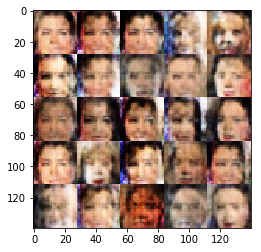

Epoch 1/1... Discriminator Loss: 1.2880... Generator Loss: 0.7763
Epoch 1/1... Discriminator Loss: 0.8792... Generator Loss: 1.2502
Epoch 1/1... Discriminator Loss: 1.1065... Generator Loss: 1.2912
Epoch 1/1... Discriminator Loss: 0.8919... Generator Loss: 1.5987
Epoch 1/1... Discriminator Loss: 1.0383... Generator Loss: 0.7803


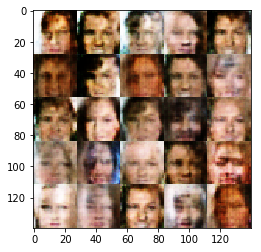

Epoch 1/1... Discriminator Loss: 0.7865... Generator Loss: 1.3809
Epoch 1/1... Discriminator Loss: 0.8648... Generator Loss: 1.3857
Epoch 1/1... Discriminator Loss: 1.1957... Generator Loss: 0.6201
Epoch 1/1... Discriminator Loss: 1.1011... Generator Loss: 0.9175
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.9159


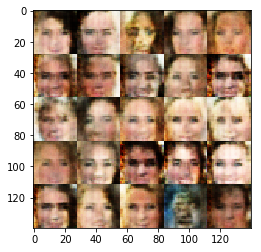

Epoch 1/1... Discriminator Loss: 1.0848... Generator Loss: 0.8293
Epoch 1/1... Discriminator Loss: 1.0133... Generator Loss: 1.1022
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.8671
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 0.9904
Epoch 1/1... Discriminator Loss: 1.1520... Generator Loss: 0.8296


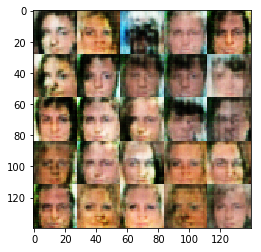

Epoch 1/1... Discriminator Loss: 1.1909... Generator Loss: 0.7446
Epoch 1/1... Discriminator Loss: 0.9974... Generator Loss: 1.0862
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 1.0867
Epoch 1/1... Discriminator Loss: 0.9163... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 1.3473... Generator Loss: 1.1762


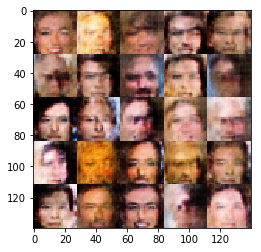

Epoch 1/1... Discriminator Loss: 0.9131... Generator Loss: 1.2456
Epoch 1/1... Discriminator Loss: 1.0651... Generator Loss: 0.7781
Epoch 1/1... Discriminator Loss: 0.9956... Generator Loss: 0.8975
Epoch 1/1... Discriminator Loss: 1.0460... Generator Loss: 0.9644
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.9636


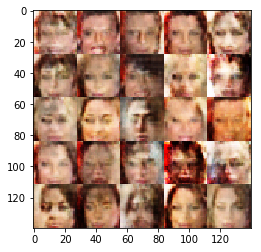

Epoch 1/1... Discriminator Loss: 1.0977... Generator Loss: 0.7738
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.8286
Epoch 1/1... Discriminator Loss: 1.2681... Generator Loss: 0.7624
Epoch 1/1... Discriminator Loss: 1.0667... Generator Loss: 0.7989
Epoch 1/1... Discriminator Loss: 1.1875... Generator Loss: 0.8781


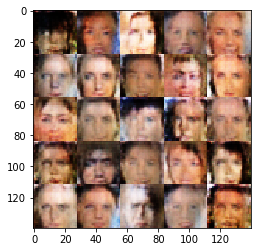

Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.9577
Epoch 1/1... Discriminator Loss: 1.0587... Generator Loss: 1.0391
Epoch 1/1... Discriminator Loss: 1.2241... Generator Loss: 0.7890
Epoch 1/1... Discriminator Loss: 1.2855... Generator Loss: 0.5846
Epoch 1/1... Discriminator Loss: 1.1307... Generator Loss: 0.7671


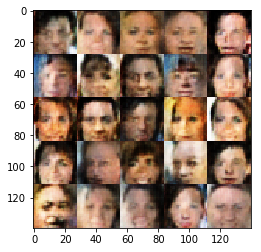

Epoch 1/1... Discriminator Loss: 1.0772... Generator Loss: 0.9860
Epoch 1/1... Discriminator Loss: 1.2363... Generator Loss: 0.5575
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.4916
Epoch 1/1... Discriminator Loss: 1.0737... Generator Loss: 0.9692
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.5814


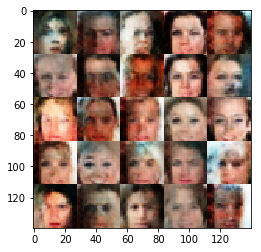

Epoch 1/1... Discriminator Loss: 1.0659... Generator Loss: 0.9957
Epoch 1/1... Discriminator Loss: 1.0569... Generator Loss: 0.8590
Epoch 1/1... Discriminator Loss: 1.0140... Generator Loss: 0.8802
Epoch 1/1... Discriminator Loss: 1.1960... Generator Loss: 0.9273
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 1.0843


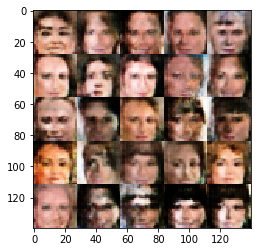

Epoch 1/1... Discriminator Loss: 1.0942... Generator Loss: 1.0195
Epoch 1/1... Discriminator Loss: 1.1547... Generator Loss: 1.0163
Epoch 1/1... Discriminator Loss: 1.0908... Generator Loss: 0.8205
Epoch 1/1... Discriminator Loss: 1.0961... Generator Loss: 0.9624
Epoch 1/1... Discriminator Loss: 0.9723... Generator Loss: 1.1242


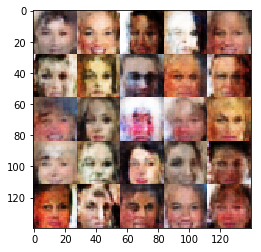

Epoch 1/1... Discriminator Loss: 1.0185... Generator Loss: 1.5068
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 1.0843
Epoch 1/1... Discriminator Loss: 1.1614... Generator Loss: 0.8339
Epoch 1/1... Discriminator Loss: 1.1193... Generator Loss: 0.8005
Epoch 1/1... Discriminator Loss: 1.1269... Generator Loss: 1.0733


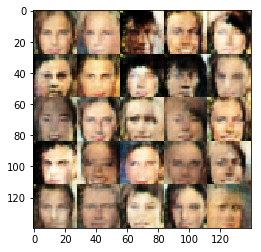

Epoch 1/1... Discriminator Loss: 1.2050... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 1.2284... Generator Loss: 1.1664
Epoch 1/1... Discriminator Loss: 1.3317... Generator Loss: 0.5021
Epoch 1/1... Discriminator Loss: 1.2892... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 1.2383... Generator Loss: 0.8454


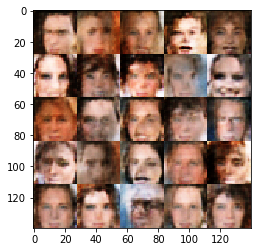

Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.5662
Epoch 1/1... Discriminator Loss: 1.1788... Generator Loss: 0.6463
Epoch 1/1... Discriminator Loss: 1.4918... Generator Loss: 0.6670
Epoch 1/1... Discriminator Loss: 0.9613... Generator Loss: 1.2332
Epoch 1/1... Discriminator Loss: 1.2693... Generator Loss: 0.9716


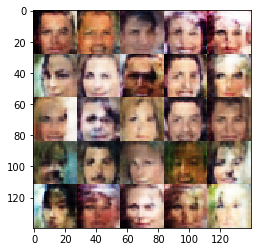

Epoch 1/1... Discriminator Loss: 1.2720... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.1474... Generator Loss: 0.9290
Epoch 1/1... Discriminator Loss: 1.2013... Generator Loss: 0.8185
Epoch 1/1... Discriminator Loss: 1.3149... Generator Loss: 0.6733


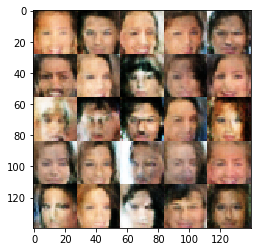

Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.5421
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.8214
Epoch 1/1... Discriminator Loss: 1.2175... Generator Loss: 0.6051


In [14]:
batch_size = 64
z_dim = 100
learning_rate = 0.0005
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.